[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1ug4By8vaGrS4XlvGPmVG1k-yG_B_WHt2?usp=sharing)

In [44]:
!pip install -q langgraph
!pip install -q tavily-python
!pip install -q langchain_mistralai
!pip install -q python-dotenv

In [45]:
from google.colab import userdata
import getpass
import os
if "MISTRAL_API_KEY" not in os.environ:
    try:
        os.environ["MISTRAL_API_KEY"] = userdata.get('MISTRAL_API_KEY')
    except Exception as e:
        os.environ["MISTRAL_API_KEY"] = getpass.getpass("Enter your MISTRAL API key: ")

In [46]:
# importing the necessary libraries
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage, ChatMessage,SystemMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder ##Dynamic prompts
from langchain_mistralai import ChatMistralAI
from typing import List, Sequence
from langgraph.graph import END, MessageGraph
from langgraph.graph import StateGraph, END


In [47]:
model = ChatMistralAI(model_name="ministral-8b-latest", temperature=0.2)

### Essay Writer

#### Definig the AgentState and Prompts

In [48]:
from typing import TypedDict, List, Annotated

class AgentState(TypedDict):
    task: str
    plan: str
    draft: str
    critique: str
    content: List[str] #Content from tavily
    revision_number: int
    max_revisions: int

In [49]:
# Defining the planning prompt
PLAN_PROMPT = '''You are an expert writer tasked with writing a high level outline of an essay.
Write such an outline for the user provided topic.
Give an outline of the essay along with any relevant notes or instructions for the sections.'''

# defining the prompt that will be used by the agent that's doing research after the planning step
# given a plan, it will generate some queries and pass them to Tavily
RESEARCH_PLAN_PROMPT = '''You are a researcher charged with providing information that can be used when writing the following essay.
Generate a list of search queries that will gather any relevant information. Only generate 3 queries max.'''

# Defining the writer prompt
WRITER_PROMPT = '''You are an essay assistant tasked with writing excellent 5-paragraph essays.
Generate the best essay possible for the user's request and the initial outline.
If the user provides critique, respond with a revised version of your previous attempts.
Utilize all the information below as needed:

------

{content}'''

# Defining the reflection prompt
REFLECTION_PROMPT = '''You are a teacher grading an essay submission.
Generate critique and recommendations for the user's submission.
Provide detailed recommendations, including requests for length, depth, style, etc.'''

# Defining the research critique prompt
RESEARCH_CRITIQUE_PROMPT = ''''You are a researcher charged with providing information that can \
be used when making any requested revisions (as outlined below).
Generate a list of search queries that will gather any relevant information. Only generate 3 queries max.'''

In [50]:
from langchain_core.pydantic_v1 import BaseModel

class Queries(BaseModel):
    queries: List[str]

In [51]:
# Importing and instantiating a tavily client
from tavily import TavilyClient
import os

tavily = TavilyClient(api_key=userdata.get('TAVILY_API_KEY'))


### Implementing the Agents and the Nodes

In [52]:
# Creating the planning node
def plan_node(state: AgentState):
    messages = [
        SystemMessage(content=PLAN_PROMPT),
        HumanMessage(content=state['task'])
    ]
    response = model.invoke(messages)
    return {"plan": response.content}

In [53]:
# Creating the reseach_plan_node
# It generates research queries based on a given task and retrieves relevant content using those queries
def research_plan_node(state: AgentState):
    queries = model.with_structured_output(Queries).invoke([
        SystemMessage(content=RESEARCH_PLAN_PROMPT),
        HumanMessage(content=state['task'])
    ])
    content = state.get('content', [])

    for q in queries.queries:
        response = tavily.search(query=q, max_results=2)
        for r in response['results']:
            content.append(r['content'])
    return {"content": content}


In [54]:
# Creating the generation node
def generation_node(state: AgentState):
    content = "\n\n".join(state['content'] or [])

    user_message = HumanMessage(
        content=f"{state['task']}\n\nHere is my plan:\n\n{state['plan']}")

    messages = [
        SystemMessage(
            content=WRITER_PROMPT.format(content=content)
        ),
        user_message
        ]

    response = model.invoke(messages)

    return {
        "draft": response.content,
        "revision_number": state.get("revision_number", 1) + 1
    }


In [55]:
# Creating the reflection node
def reflection_node(state: AgentState):
    messages = [
        SystemMessage(content=REFLECTION_PROMPT),
        HumanMessage(content=state['draft'])
    ]
    response = model.invoke(messages)
    return {"critique": response.content}



In [56]:
# Creating the research critique node
def research_critique_node(state: AgentState):
    queries = model.with_structured_output(Queries).invoke([
        SystemMessage(content=RESEARCH_CRITIQUE_PROMPT),
        HumanMessage(content=state['critique'])
    ])
    content = state['content'] or []
    for q in queries.queries:
        response = tavily.search(query=q, max_results=2)
        for r in response['results']:
            content.append(r['content'])
    return {'content': content}


## Defining the Conditional Edge

In [57]:
# Defining the conditional edge
def should_continue(state):
    if state['revision_number'] > state['max_revisions']:
        return END
    return 'reflect'

## Defining the Graph

In [58]:
builder = StateGraph(AgentState)

# Adding nodes to the graph
builder.add_node('planner', plan_node)
builder.add_node('generate', generation_node)
builder.add_node('reflect', reflection_node)
builder.add_node('research_plan', research_plan_node)
builder.add_node('research_critique', research_critique_node)

# Setting the entry point of the state graph
builder.set_entry_point('planner')

# Adding the conditional edge
builder.add_conditional_edges(
    'generate',
    should_continue,
    {END: END, 'reflect': 'reflect'}
)

# Adding regular edges
builder.add_edge('planner', 'research_plan')
builder.add_edge('research_plan', 'generate')

builder.add_edge('reflect', 'research_critique')
builder.add_edge('research_critique', 'generate')


In [59]:
!pip install -q langgraph-checkpoint-sqlite

In [60]:
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.checkpoint.memory import MemorySaver

memory = SqliteSaver.from_conn_string(':memory:')

# graph = builder.compile(checkpointer=memory) # fix - change to this:
graph = builder.compile(checkpointer=MemorySaver())

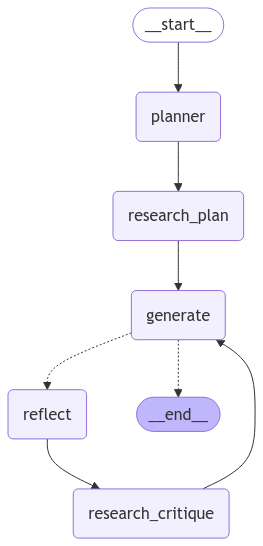

In [61]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))


In [62]:
thread = {'configurable': {'thread_id': '555'}}
task = 'Assey on researchers from University of Cagliari'

prompt = {
    'task': task,
    'max_revisions': 5,
    'revision_number': 2,
}

events = graph.stream(prompt, thread)
for e in events:
    print(e)
    print('-' * 100)

{'planner': {'plan': '**Essay Title: The Contributions of Researchers from the University of Cagliari to the Field of [Specific Field]**\n\n**I. Introduction**\n   - A. Brief overview of the University of Cagliari\n   - B. Importance of the specific field of study\n   - C. Thesis statement: Highlight the significant contributions of researchers from the University of Cagliari to the field\n\n**II. Historical Context and Background**\n   - A. Brief history of the University of Cagliari\n   - B. Evolution of the specific field of study within the university\n   - C. Notable early researchers and their contributions\n\n**III. Key Researchers and Their Contributions**\n   - A. **Researcher 1**\n      1. Brief biography\n      2. Major contributions to the field\n      3. Impact on the field and broader scientific community\n   - B. **Researcher 2**\n      1. Brief biography\n      2. Major contributions to the field\n      3. Impact on the field and broader scientific community\n   - C. **

In [63]:
from IPython.display import Markdown

def display_markdown(text):
    return Markdown(text)

display_markdown(e['generate']['draft'])

**Essay Title: The Contributions of Researchers from the University of Cagliari to the Field of Artificial Intelligence and Human-Computer Interaction**

**I. Introduction**
   - A. Brief overview of the University of Cagliari: The University of Cagliari, located in Cagliari, Italy, is a prominent institution known for its robust research programs and interdisciplinary approach. With a strong focus on innovation and collaboration, the university has made significant strides in various fields, including Artificial Intelligence (AI) and Human-Computer Interaction (HCI).
   - B. Importance of the specific field of study: AI and HCI are rapidly evolving fields that have a profound impact on technology, society, and daily life. They are crucial for developing intelligent systems that can understand, respond to, and interact with humans effectively.
   - C. Thesis statement: Researchers from the University of Cagliari have made substantial contributions to the fields of AI and HCI, driving innovation and shaping the future of these disciplines.

**II. Historical Context and Background**
   - A. Brief history of the University of Cagliari: Founded in 1920, the University of Cagliari has a rich history of academic excellence and research innovation. It has evolved over the years to become a leading institution in Italy and Europe.
   - B. Evolution of AI and HCI within the university: The university has been at the forefront of AI and HCI research, with a strong focus on developing intelligent user interfaces and exploring the intersection of AI and HCI.
   - C. Notable early researchers and their contributions: Early researchers at the University of Cagliari, such as Professor Marco Livesu, have laid the groundwork for the current research landscape in AI and HCI.

**III. Key Researchers and Their Contributions**
   - A. **Researcher 1: Professor Marco Livesu**
      1. Brief biography: Professor Marco Livesu is a senior researcher at the University of Cagliari and the Italian National Research Council (CNR). He has extensive experience in AI and HCI, with a focus on intelligent user interfaces.
      2. Major contributions to the field: Professor Livesu has made significant contributions to the development of intelligent user interfaces, including the design and implementation of AI-driven systems that enhance user experience.
      3. Impact on the field and broader scientific community: His work has been widely recognized and has influenced the development of AI and HCI in both academic and industrial settings.
   - B. **Researcher 2: Dr. Federico Maria Cau**
      1. Brief biography: Dr. Federico Maria Cau is a researcher at the University of Cagliari and has a strong background in AI and HCI. He has been involved in various research projects and collaborations.
      2. Major contributions to the field: Dr. Cau has contributed to the field by developing innovative methodologies for AI-assisted decision-making and exploring the impact of curiosity traits on AI systems.
      3. Impact on the field and broader scientific community: His research has been published in prestigious journals and has received international recognition.
   - C. **Researcher 3: Dr. Lucio Davide Spano**
      1. Brief biography: Dr. Lucio Davide Spano is a visiting researcher at the University of Primorska and a co-teacher of the HCI course at the University of Primorska. He has a strong background in AI and HCI and has been involved in various research projects.
      2. Major contributions to the field: Dr. Spano has contributed to the field by developing intelligent user interfaces for generative AI and exploring the impact of AI on human decision-making.
      3. Impact on the field and broader scientific community: His work has been published in leading conferences and journals, and he has received numerous awards and recognitions.

**IV. Methodological Innovations**
   - A. Unique approaches and methodologies developed by researchers from the University of Cagliari: Researchers at the University of Cagliari have developed innovative methodologies for AI and HCI, including the use of netnography, child-led research, and creative methods.
   - B. How these innovations have advanced the field: These methodologies have advanced the field by providing new insights into user behavior, enhancing the design of intelligent systems, and improving the user experience.
   - C. Case studies or examples illustrating these innovations: For example, the use of netnography has been employed to study user behavior in online communities, while child-led research has been used to involve children in the design of AI systems.

**V. Collaborations and Interdisciplinary Work**
   - A. Collaborations with other universities and institutions: Researchers at the University of Cagliari have collaborated with other universities and institutions, both in Italy and internationally, to advance AI and HCI research.
   - B. Interdisciplinary research projects: The university has engaged in interdisciplinary research projects that combine expertise from various fields, such as psychology, computer science, and engineering.
   - C. Impact of these collaborations on the field: These collaborations have led to the development of innovative AI and HCI systems and have enhanced the understanding of the intersection between AI and HCI.

**VI. Current Research Trends and Future Directions**
   - A. Ongoing research projects at the University of Cagliari: The university is currently involved in various research projects that focus on AI and HCI, including the development of intelligent user interfaces for healthcare and autonomous vehicles.
   - B. Emerging trends in the field: Some of the emerging trends in AI and HCI include the use of generative AI, the development of AI-driven chatbots, and the exploration of AI ethics and transparency.
   - C. Potential future directions and implications: Future research at the University of Cagliari is likely to focus on the development of AI systems that can adapt to user needs, the exploration of AI ethics, and the integration of AI and HCI in various industries.

**VII. Conclusion**
   - A. Recap of the significant contributions of researchers from the University of Cagliari: Researchers from the University of Cagliari have made substantial contributions to the fields of AI and HCI, driving innovation and shaping the future of these disciplines.
   - B. The enduring impact of their work on the field: Their work has had a lasting impact on the field, influencing the development of AI and HCI systems and enhancing the user experience.
   - C. Final thoughts on the importance of continued research and innovation: Continued research and innovation in AI and HCI are crucial for addressing the challenges and opportunities presented by these rapidly evolving fields.

**References**
- [Insert relevant sources and references here]